# Autoencoders and an introduction to Artificial Neural Networks
Chapter 7 introduces us to Autoencoders, which are an unsupervised type of Artificial Neural Network (ANN) that can represent source input data in a compact fashion (_encoding step_) and restore the data from its compact form to a resonable facisimle (_decoding step_). One of the really cool properties about Autoencoders is that they are a form of ANN and Neural Network (NN) that can arbitrarily encode _any_ function so long as the following things hold true: (1) they include at least _one hidden layer_ or layer that cannot be directly manipulated as part of the network (other than its size) and (2) that the output of the encoding step is non-linear, and as such it uses an _activation function_ which turns the encoding step of the network into something non-linear. Examples of these functions include ones we've seen before as introduced in the book, e.g., _sigmoid_ (chapter 4), _tangent (tan)_ or a new one introduced, but not explained, _ReLU_ or _rectifying linear unit_. A side property of these functions is to not only turn the network non-linear, but also to represent _activation_ of the _neuron_ (really just one of the hidden layer values). If the neuron _fires_ then its activation is said to be represented by the non-linear function as _active_. So for example, in sigmoid, this would mean a resultant value of *1* or *0* if it hasn't fired and so on. Autoencoders have many uses in real life outside of data compression, for example:

   1. Anomaly Detection - If the Autoencoder learns a representation of a set of images, for example, and then another image that doesn't have a similar learned representation is provided to the network, the loss function variance should be quite different from those images trained in the network.
   2. De-noising - If provided an image containing ample noise (e.g., taken by a bad instrument or source, or manipulated in some way, through the internally learned representation of the network, the decoding step can actually restore or de-noise the image to its original or close to original form.
   3. Generative Neworks - for example to combine a learned representation of a bat, and a horse to generate (by averaging or using means) a "horse bat" or other things not seen before.
   
The book doesn't include an end of chapter assignment suggestion, but the last thing you do in the book for this listing (7.9-7.13) is to download some images from the [CIFAR-10 Python Dataset](http://www.cs.toronto.edu/~kriz/cifar.html) which are labeled images from the [80 million tiny images dataset](http://people.csail.mit.edu/torralba/tinyimages/) of 10 classes/types of objects, and then to represent the images (*32 x 32* pixels in *RGB* format) using an Autoencoder. In particular the book shows you how to take the image, represent an image of 32x32 pixels in row major order (e.g., as a vector of \[1x1024\] pixels) and then for the R,G,B values in each pixel, how to average them into a greyscale intensity. From there, you can select, e.g., all the pictures of horses (5000 images), and build an Autoencoder network using Tensorflow to encode and decode the image and test out the learned representations of them image(s). 

I had to dig around in the book code for some additional examples beyond this. I found [Ch07 Examples](https://github.com/BinRoot/TensorFlow-Book/tree/master/ch07_autoencoder) that had some cool additional things to check out, in particular:

   1. Image plotting code to show you the horses you are selecting, and also to plot their learned representations, so you can visualize the input and output of the network from CIFAR-10.
   2. Code to perform a _classify_ function - yes - Autoencoders can be used similar to regression techniques to take their learned representation and classify things of a particular type (e.g., train up on horse images, and then use the learned loss as a differentiator for other types of images (e.g., of a dog). Interestingly, the variation is small (likely due to the smallness of the images), only about *1.5* but it's still statistically significant and obviously this is something that you can threshold when building a classifier of a particular type. For example I imagine if you were to build a gun classifier for a particular type of semi-automatic gun, you would train on a bunch of those images into an Autoencoder network, and then test it against some other gun types to figure out the right loss-threshold balance that signifies the class of semi-automatic in a meaningful way.
   3. Code to do a De-Noising Autoencoder, see [this example](https://github.com/BinRoot/TensorFlow-Book/blob/master/ch07_autoencoder/Concept03_denoising.ipynb). I didn't play around with it directly but it is similar to this [other example](https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py) I found though that example uses another style of Tensorflow network construction which looks to be more explicit than the implicit way the book is teaching us.
   4. Code to do a Deep Autoencoder, or [Stacked Autoencoder](https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3) like is discussed in the book. Ended up hooking this up to the Tensorflow Dataset API for fun.
   
I made a diagram of the encoding and decoding process. I was thinking of doing an assignment to build e.g., an automatic weapons classifier or "long gun" or something classifier as I was motivated by some of the prior [DARPA MEMEX](http://memex.jpl.nasa.gov/) work we did in the area. I may do one, but I understand the concept enough now that I felt I would simply annotate the last listings and move on to the next chapter.

![Autoencoder Process](figs/ch07-autoencoder.png)

## References

   1. [CIFAR-10/-100 dataset](http://www.cs.toronto.edu/~kriz/cifar.html) - the key data used to illustrate the Autoencoder concepts.
   2. [Stanford's Unsupervised Learning Autoencoder chapter](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/) - A fantastic theoretical introduction to Autoencoders. A bit out of my league in the math, but worth a look if you want to understand the core theory.
   3. [Wikipedia article on Autoencoders](https://en.wikipedia.org/wiki/Autoencoder) - Besides the theory has some good use cases that explain what an Autoencoder is for.
   4. [Autoencoders and the CIFAR dataset](https://www.guru99.com/autoencoder-deep-learning.html) - Looks like this is where the book chose its examples from for Tensorflow although the examples here use the more explicit network creation methods in Tensorflow rather than the implicit stuff taught in the book.
   5. [Deep Autoencoders and Dimensionality Reduction](https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3) - Shows how Autoencoders are similar to PCA and other dimensionality reduction techniques.
   6. [Different use cases for Autoencoders](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726) - Shows how Autoencoders are used for different use cases. 
   7. [Deep AutoEncoders using TensorFlow - Towards Data Science](https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3) - Great post for a 3 dimensional Deep auto encoder on MNIST. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle
import time

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mat

In [2]:
def get_batch(X, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a]

class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch=1000, batch_size=50, learning_rate=0.001):
        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.sigmoid(tf.matmul(x, weights) + biases)
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases

        self.x = x
        self.encoded = encoded
        self.decoded = decoded

        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        
        self.saver = tf.train.Saver()

    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                for j in range(np.shape(data)[0] // self.batch_size):
                    batch_data = get_batch(data, self.batch_size)
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
                if i % 10 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
            self.saver.save(sess, './model.ckpt')
        
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
            reconstructed = reconstructed[0]
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden

    def decode(self, encoding):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            reconstructed = sess.run(self.decoded, feed_dict={self.encoded: encoding})
        img = np.reshape(reconstructed, (32, 32))
        return img


In [3]:
def get_batch_n(X, Xn, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a], Xn[a]


class Denoiser:

    def __init__(self, input_dim, hidden_dim, epoch=10000, batch_size=50, learning_rate=0.001):
        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x')
        self.x_noised = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='x_noised')
        with tf.name_scope('encode'):
            self.weights1 = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            self.biases1 = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            self.encoded = tf.nn.sigmoid(tf.matmul(self.x_noised, self.weights1) + self.biases1, name='encoded')
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            self.decoded = tf.matmul(self.encoded, weights) + biases
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()

    def add_noise(self, data):
        noise_type = 'mask-0.2'
        if noise_type == 'gaussian':
            n = np.random.normal(0, 0.1, np.shape(data))
            return data + n
        if 'mask' in noise_type:
            frac = float(noise_type.split('-')[1])
            temp = np.copy(data)
            for i in temp:
                n = np.random.choice(len(i), round(frac * len(i)), replace=False)
                i[n] = 0
            return temp

    def train(self, data):
        data_noised = self.add_noise(data)
        with open('log.csv', 'w') as writer:
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for i in range(self.epoch):
                    for j in range(50):
                        batch_data, batch_data_noised = get_batch_n(data, data_noised, self.batch_size)
                        l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data, self.x_noised: batch_data_noised})
                    if i % 10 == 0:
                        print('epoch {0}: loss = {1}'.format(i, l))
                        self.saver.save(sess, './model.ckpt')
                        epoch_time = int(time.time())
                        row_str = str(epoch_time) + ',' + str(i) + ',' + str(l) + '\n'
                        writer.write(row_str)
                        writer.flush()
                self.saver.save(sess, './model.ckpt')

    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            data_noised = self.add_noise(data)
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data, self.x_noised:data_noised})
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            data_noised = self.add_noise(data)
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data, self.x_noised:data_noised})
            reconstructed = reconstructed[0]
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden

    def get_params(self):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            weights, biases = sess.run([self.weights1, self.biases1])
        return weights, biases
    
    def decode(self, encoding):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            reconstructed = sess.run(self.decoded, feed_dict={self.encoded: encoding})
        img = np.reshape(reconstructed, (32, 32))
        return img

In [4]:
class StackedAutoencoder:
    def __init__(self, input_dim, num_hidden_layers=3, epoch=100, batch_size=250, learning_rate=0.01):
        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.idim = [None]*num_hidden_layers
        self.hdim = [None]*num_hidden_layers
        self.hidden = [None]*num_hidden_layers
        self.weights = [None]*num_hidden_layers
        self.biases = [None]*num_hidden_layers

        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        initializer=tf.variance_scaling_initializer()
        #initializer=tf.random.normal
        output_dim = input_dim
        act=tf.nn.relu
        
        # network construction - [input to hidden]            
        for i in range(0, num_hidden_layers):
            self.idim[i] = int(input_dim / (2*i)) if i else input_dim 
            self.hdim[i] = int(input_dim / (2*(i+1))) if i < num_hidden_layers-1 else int(input_dim/2)
            print('%s, weights [%d, %d] biases %d' % ("hidden layer "+str(i+1) if i else "input to hidden layer 1", self.idim[i], self.hdim[i], self.hdim[i]))
            self.weights[i] = tf.Variable(initializer([self.idim[i], self.hdim[i]]), dtype=tf.float32, name='weights'+str(i))
            self.biases[i] = tf.Variable(tf.zeros([self.hdim[i]]), name='biases'+str(i))
            
            if i == 0:
                self.hidden[i] = act(tf.matmul(x, self.weights[i]) + self.biases[i])
            else:
                self.hidden[i] = act(tf.matmul(self.hidden[i-1], self.weights[i]) + self.biases[i])
        
        #output layer
        print('output layer, weights [%d, %d] biases %d' % (self.hdim[num_hidden_layers-1], output_dim, output_dim))
        self.output_weight = tf.Variable(initializer([self.hdim[num_hidden_layers-1], output_dim]), dtype=tf.float32, name='output_weight')
        self.output_bias = tf.Variable(tf.zeros([output_dim]), name='output_bias')
        self.output_layer = act(tf.matmul(self.hidden[num_hidden_layers-1], self.output_weight)+self.output_bias)


        self.x = x
        self.loss = tf.reduce_mean(tf.square(self.output_layer-self.x))
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        #self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.output_layer))))
        #self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        
        self.saver = tf.train.Saver()

    def train(self, data):
        features = data
        features_placeholder = tf.placeholder(features.dtype, features.shape)
        dataset = tf.data.Dataset.from_tensor_slices((features_placeholder))
        dataset = dataset.shuffle(buffer_size=100)
        dataset = dataset.batch(self.batch_size)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                batch_num=0
                iter = dataset.make_initializable_iterator()
                sess.run(iter.initializer, feed_dict={features_placeholder: features})
                iter_op = iter.get_next()
                
                while True:
                    try:
                        batch_data = sess.run(iter_op)
                        l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
                        batch_num += 1
                    except tf.errors.OutOfRangeError:
                        break
                
                print('epoch {0}: loss = {1}'.format(i, l))
                self.saver.save(sess, './model.ckpt')
        
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.hidden[num_hidden_layers-1], self.output_layer], feed_dict={self.x: data})
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.hidden[num_hidden_layers-1], self.output_layer], feed_dict={self.x: data})
            reconstructed = reconstructed[0]
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden

    def decode(self, encoding):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            reconstructed = sess.run(self.output_layer, feed_dict={self.hidden[num_hidden_layers-1]: encoding})
        img = np.reshape(reconstructed, (32, 32))
        return img
    
    def results(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            results = sess.run(self.output_layer, feed_dict={self.x:data})
        
        return results

In [5]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [6]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [7]:
names = unpickle('./cifar-10-batches-py/batches.meta')['label_names']
data, labels = [], []
for i in range(1, 6):
    filename = './cifar-10-batches-py/data_batch_' + str(i)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']

In [8]:
data = grayscale(data)

In [9]:
x = np.matrix(data)
y = np.array(labels)
print(np.shape(x))
print(y)

(50000, 1024)
[6 9 9 ... 9 1 1]


In [10]:
horse_indices = np.where(y == 7)[0]
horse_x = x[horse_indices]
print(np.shape(horse_x))  # (5000, 3072)

(5000, 1024)


Some examples of horse images we will feed to the autoencoder for training


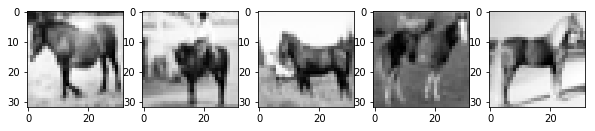

In [11]:
print('Some examples of horse images we will feed to the autoencoder for training')
plt.rcParams['figure.figsize'] = (10, 10)
num_examples = 5
for i in range(num_examples):
    horse_img = np.reshape(horse_x[i, :], (32, 32))
    plt.subplot(1, num_examples, i+1)
    plt.imshow(horse_img, cmap='Greys_r')
plt.show()

In [12]:
input_dim = np.shape(horse_x)[1]
hidden_dim = 100
ae = Autoencoder(input_dim, hidden_dim)
ae.train(horse_x)

Instructions for updating:
Colocations handled automatically by placer.
epoch 0: loss = 134.70655822753906
epoch 10: loss = 76.6200180053711
epoch 20: loss = 59.698158264160156
epoch 30: loss = 56.75909423828125
epoch 40: loss = 58.73681640625
epoch 50: loss = 56.75621032714844
epoch 60: loss = 55.0696907043457
epoch 70: loss = 56.482704162597656
epoch 80: loss = 58.043582916259766
epoch 90: loss = 55.9791145324707
epoch 100: loss = 58.27439498901367
epoch 110: loss = 54.414756774902344
epoch 120: loss = 54.83662796020508
epoch 130: loss = 56.303009033203125
epoch 140: loss = 54.7895622253418
epoch 150: loss = 51.1730842590332
epoch 160: loss = 51.82255172729492
epoch 170: loss = 52.26374435424805
epoch 180: loss = 53.2486686706543
epoch 190: loss = 53.79853057861328
epoch 200: loss = 51.772422790527344
epoch 210: loss = 55.62279510498047
epoch 220: loss = 55.52330017089844
epoch 230: loss = 47.38302230834961
epoch 240: loss = 48.82627868652344
epoch 250: loss = 49.05672073364258
epoch

In [13]:
test_data = unpickle('./cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])
test_horse_indices = np.where(test_labels==7)[0]
test_horse = test_x[test_horse_indices]
encodings = ae.classify(test_x, test_labels)
encodings_horse = encodings[test_horse_indices]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt
data (10000, 1024)
reconstructed (1024,)
loss (10000,)
horse 63.19770728235271
not horse 61.771580430829474


In [14]:
ae.test(test_horse)

INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[ 34.          60.66666667  36.33333333 ...   5.           3.66666667
    5.        ]
 [111.66666667 120.         116.         ... 205.66666667 204.33333333
  206.        ]
 [ 48.33333333  66.66666667  86.66666667 ... 135.33333333 133.66666667
  140.        ]
 ...
 [ 29.          43.33333333  58.66666667 ... 151.         151.33333333
  147.33333333]
 [100.66666667 108.66666667 109.66666667 ... 143.33333333 128.66666667
   85.33333333]
 [ 75.33333333 104.66666667 106.33333333 ... 108.33333333  63.66666667
   26.33333333]]
compressed [[0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
reconstructed [[ 88.69392   93.134995  93.69954  ...  49.1538    53.48016   57.427284]
 [104.61283  101.96864  102.228165 ... 159.11684  158.36711  159.06337 ]
 [205.88844  204.99907  205.80833  ... 106.32716  107.85627  110.11922 ]
 ...
 [ 77.

array([[ 88.69392 ,  93.134995,  93.69954 , ...,  49.1538  ,  53.48016 ,
         57.427284],
       [104.61283 , 101.96864 , 102.228165, ..., 159.11684 , 158.36711 ,
        159.06337 ],
       [205.88844 , 204.99907 , 205.80833 , ..., 106.32716 , 107.85627 ,
        110.11922 ],
       ...,
       [ 77.93032 ,  76.28443 ,  76.910736, ..., 139.74327 , 139.15686 ,
        138.78288 ],
       [171.00897 , 170.47668 , 172.95482 , ..., 149.24767 , 148.32034 ,
        151.43066 ],
       [185.52625 , 183.34001 , 182.78853 , ..., 125.33179 , 127.04839 ,
        129.3505  ]], dtype=float32)

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

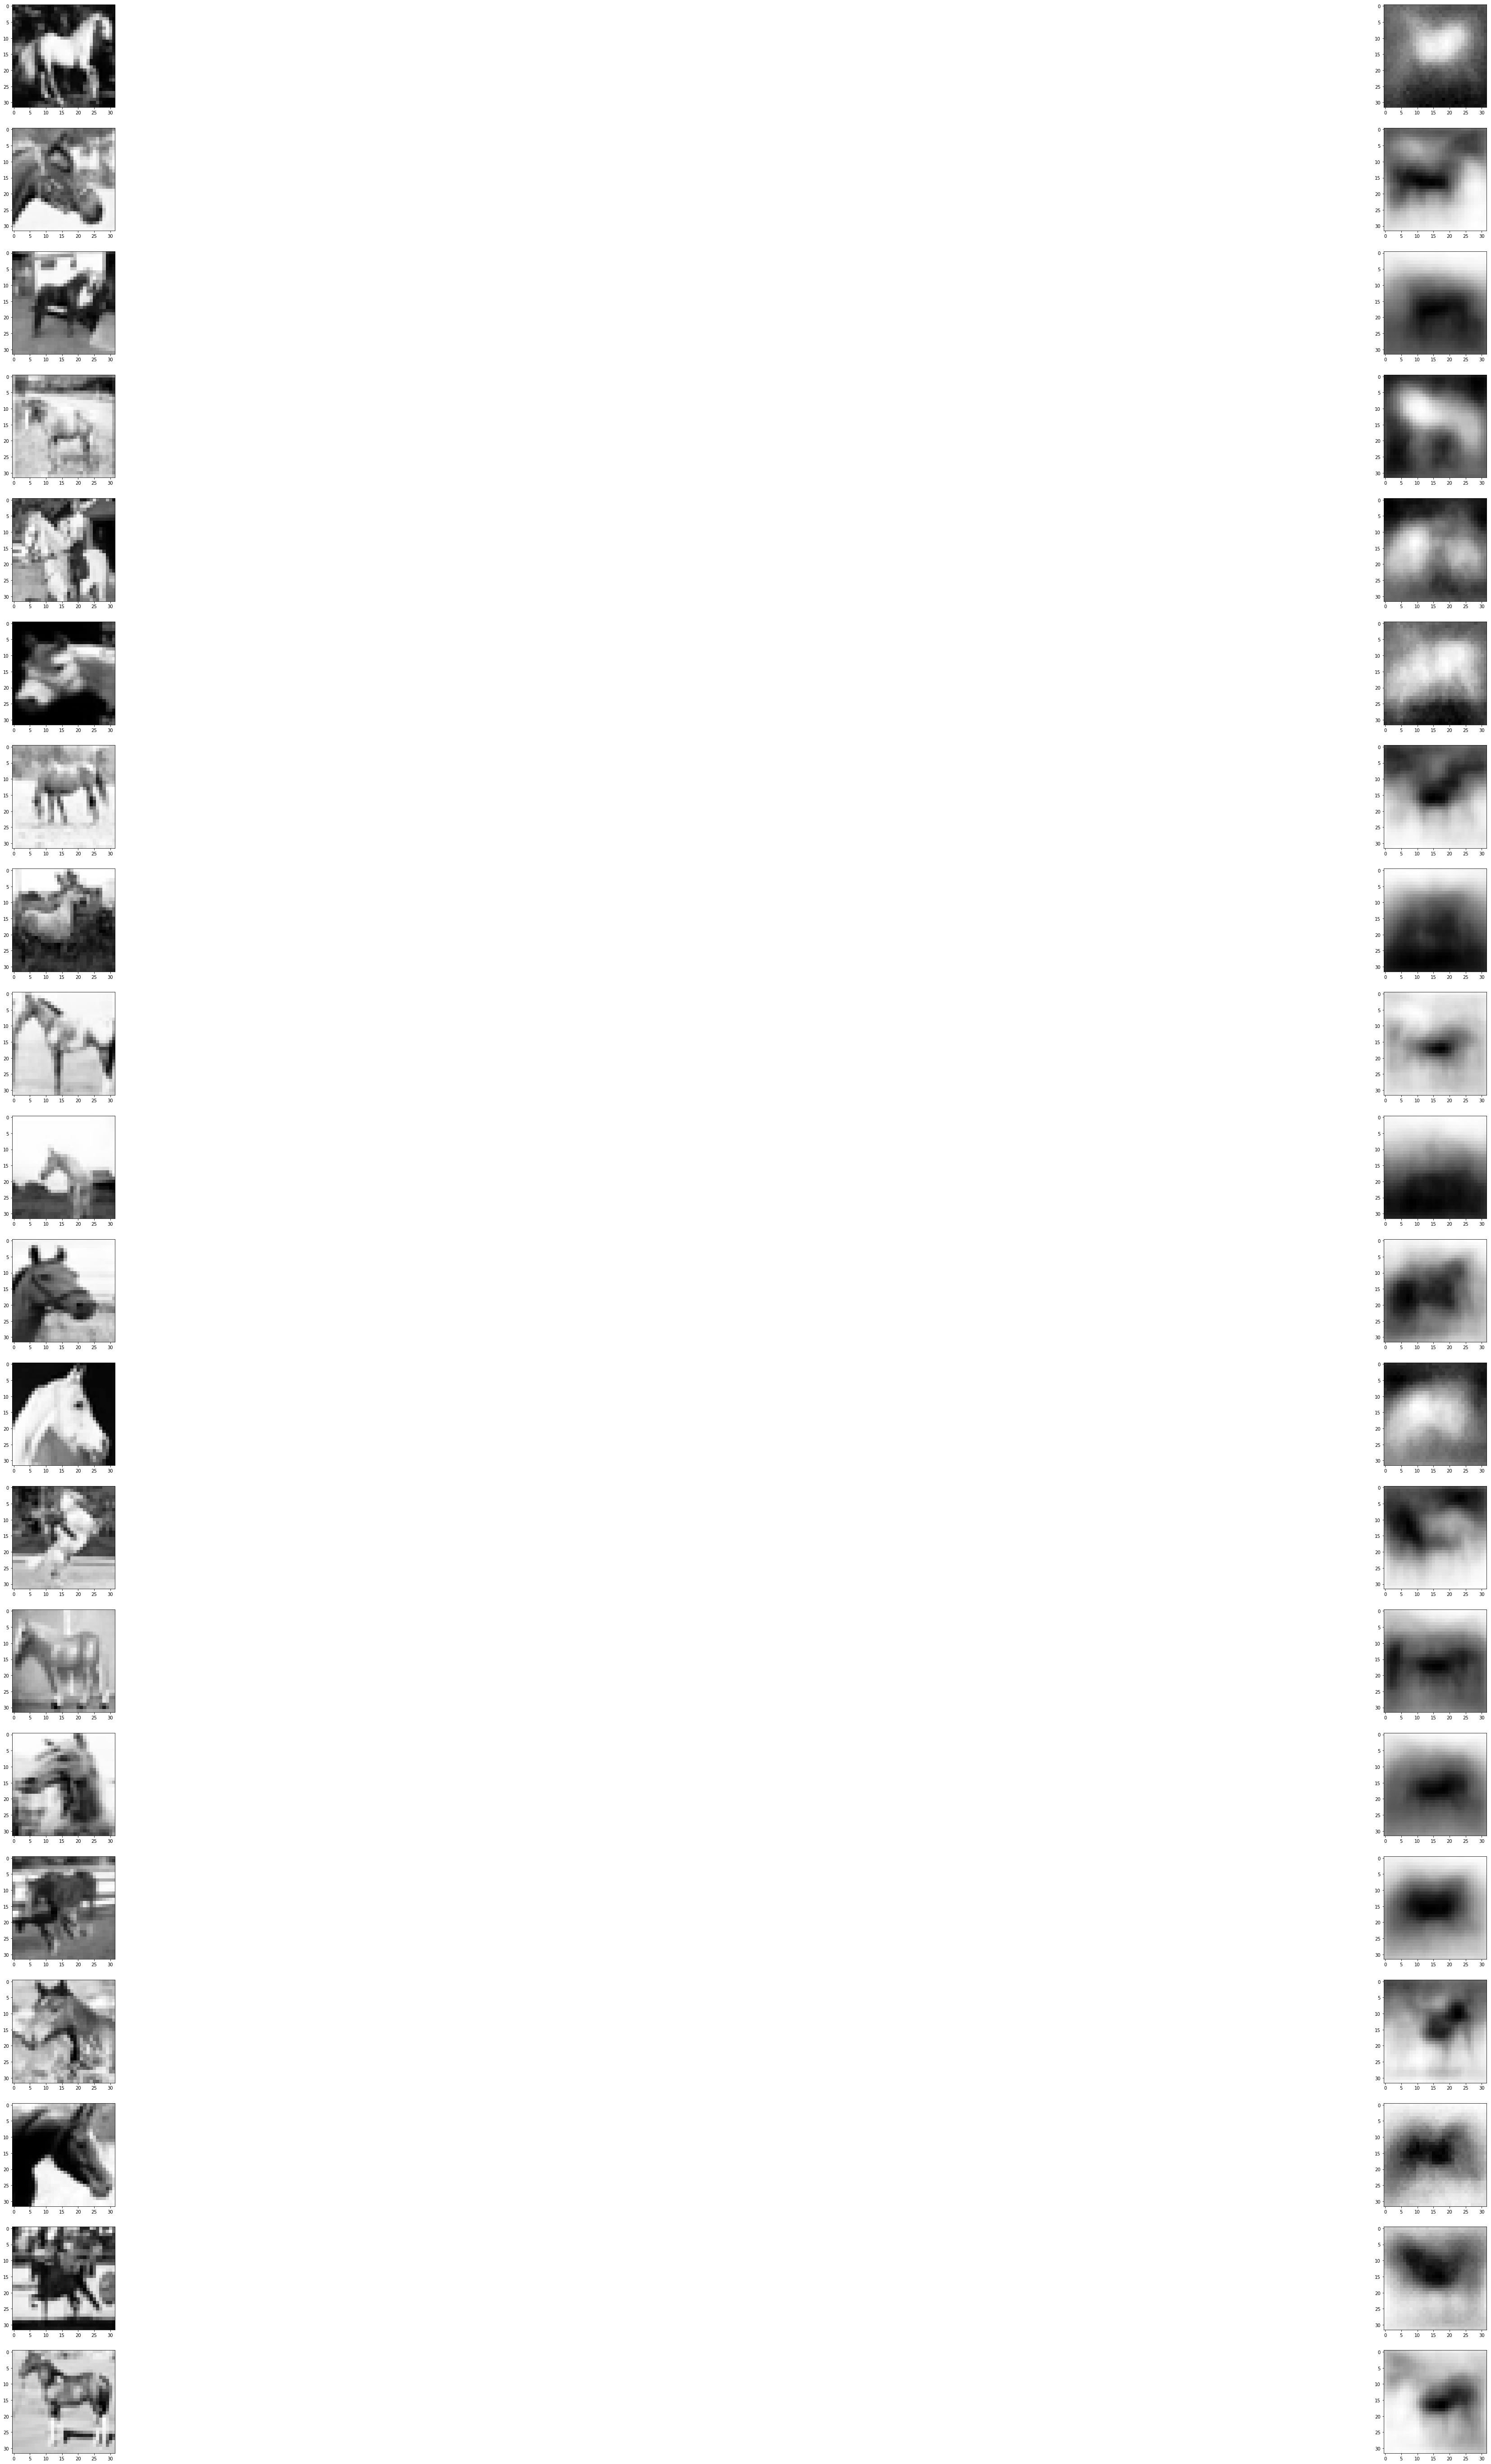

In [15]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_horse[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = ae.decode([encodings_horse[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show()

In [16]:
ae_dn = Denoiser(input_dim, hidden_dim)
ae_dn.train(horse_x)

epoch 0: loss = 136.20144653320312
epoch 10: loss = 82.30155181884766
epoch 20: loss = 65.52864074707031
epoch 30: loss = 61.11537551879883
epoch 40: loss = 58.64824676513672
epoch 50: loss = 57.06584548950195
epoch 60: loss = 63.34699249267578
epoch 70: loss = 56.45360565185547
epoch 80: loss = 62.18100357055664
epoch 90: loss = 63.330299377441406
epoch 100: loss = 60.590877532958984
epoch 110: loss = 61.22947692871094
epoch 120: loss = 57.150428771972656
epoch 130: loss = 61.461490631103516
epoch 140: loss = 57.914878845214844
epoch 150: loss = 57.73579406738281
epoch 160: loss = 55.23517990112305
epoch 170: loss = 57.21604537963867
epoch 180: loss = 55.61872863769531
epoch 190: loss = 58.0911750793457
epoch 200: loss = 57.00532531738281
epoch 210: loss = 58.58672332763672
epoch 220: loss = 62.33918762207031
epoch 230: loss = 55.00377655029297
epoch 240: loss = 58.59171676635742
epoch 250: loss = 57.06535720825195
epoch 260: loss = 56.91791915893555
epoch 270: loss = 58.1469688415527

epoch 2240: loss = 49.584503173828125
epoch 2250: loss = 48.373687744140625
epoch 2260: loss = 49.86018371582031
epoch 2270: loss = 51.900230407714844
epoch 2280: loss = 47.52165985107422
epoch 2290: loss = 47.759864807128906
epoch 2300: loss = 56.48432159423828
epoch 2310: loss = 50.32692337036133
epoch 2320: loss = 47.61631393432617
epoch 2330: loss = 50.35613250732422
epoch 2340: loss = 48.268123626708984
epoch 2350: loss = 52.36358642578125
epoch 2360: loss = 51.6676139831543
epoch 2370: loss = 48.347354888916016
epoch 2380: loss = 48.282073974609375
epoch 2390: loss = 50.2589225769043
epoch 2400: loss = 45.6805534362793
epoch 2410: loss = 49.44049835205078
epoch 2420: loss = 48.58516311645508
epoch 2430: loss = 47.926456451416016
epoch 2440: loss = 46.77354049682617
epoch 2450: loss = 48.559410095214844
epoch 2460: loss = 50.13129806518555
epoch 2470: loss = 50.70633316040039
epoch 2480: loss = 49.828895568847656
epoch 2490: loss = 48.00738525390625
epoch 2500: loss = 50.597721099

epoch 4440: loss = 49.50021743774414
epoch 4450: loss = 51.591243743896484
epoch 4460: loss = 45.422935485839844
epoch 4470: loss = 48.27490234375
epoch 4480: loss = 51.392818450927734
epoch 4490: loss = 49.903106689453125
epoch 4500: loss = 48.93817901611328
epoch 4510: loss = 47.99630355834961
epoch 4520: loss = 47.95602035522461
epoch 4530: loss = 50.271297454833984
epoch 4540: loss = 49.76985168457031
epoch 4550: loss = 50.710391998291016
epoch 4560: loss = 49.96522903442383
epoch 4570: loss = 47.439693450927734
epoch 4580: loss = 52.96059036254883
epoch 4590: loss = 52.08955383300781
epoch 4600: loss = 47.666465759277344
epoch 4610: loss = 50.00369644165039
epoch 4620: loss = 50.1094856262207
epoch 4630: loss = 48.153629302978516
epoch 4640: loss = 46.38949966430664
epoch 4650: loss = 48.86344909667969
epoch 4660: loss = 49.86899948120117
epoch 4670: loss = 49.22301483154297
epoch 4680: loss = 46.76506042480469
epoch 4690: loss = 50.26519775390625
epoch 4700: loss = 55.81621551513

epoch 6650: loss = 46.91471481323242
epoch 6660: loss = 50.52634048461914
epoch 6670: loss = 54.774600982666016
epoch 6680: loss = 48.010040283203125
epoch 6690: loss = 51.711204528808594
epoch 6700: loss = 48.78398132324219
epoch 6710: loss = 48.441402435302734
epoch 6720: loss = 49.968170166015625
epoch 6730: loss = 50.157432556152344
epoch 6740: loss = 47.3831787109375
epoch 6750: loss = 51.879852294921875
epoch 6760: loss = 46.6565055847168
epoch 6770: loss = 52.260765075683594
epoch 6780: loss = 51.2909049987793
epoch 6790: loss = 46.97080612182617
epoch 6800: loss = 45.372955322265625
epoch 6810: loss = 47.34000778198242
epoch 6820: loss = 49.872066497802734
epoch 6830: loss = 51.63579177856445
epoch 6840: loss = 48.94890213012695
epoch 6850: loss = 47.28165054321289
epoch 6860: loss = 46.644439697265625
epoch 6870: loss = 46.6440315246582
epoch 6880: loss = 47.92671203613281
epoch 6890: loss = 50.2474479675293
epoch 6900: loss = 49.47257614135742
epoch 6910: loss = 47.9000053405

epoch 8860: loss = 51.295650482177734
epoch 8870: loss = 48.289634704589844
epoch 8880: loss = 48.17900848388672
epoch 8890: loss = 44.9462890625
epoch 8900: loss = 50.697715759277344
epoch 8910: loss = 49.94538116455078
epoch 8920: loss = 47.72711181640625
epoch 8930: loss = 50.32904052734375
epoch 8940: loss = 49.54374694824219
epoch 8950: loss = 46.0238037109375
epoch 8960: loss = 47.22956085205078
epoch 8970: loss = 50.96942138671875
epoch 8980: loss = 47.2328987121582
epoch 8990: loss = 47.18669891357422
epoch 9000: loss = 48.98457717895508
epoch 9010: loss = 48.55070877075195
epoch 9020: loss = 51.93474197387695
epoch 9030: loss = 50.648681640625
epoch 9040: loss = 48.14912796020508
epoch 9050: loss = 53.74760055541992
epoch 9060: loss = 47.853214263916016
epoch 9070: loss = 47.495208740234375
epoch 9080: loss = 49.89973449707031
epoch 9090: loss = 49.847145080566406
epoch 9100: loss = 50.51409912109375
epoch 9110: loss = 48.33722686767578
epoch 9120: loss = 45.94873046875
epoch 

In [17]:
encodings = ae_dn.classify(test_x, test_labels)
encodings_horse = encodings[test_horse_indices]

INFO:tensorflow:Restoring parameters from ./model.ckpt
data (10000, 1024)
reconstructed (1024,)
loss (10000,)
horse 61.12571251705483
not horse 61.106683374373304


In [18]:
ae_dn.test(horse_x)

INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[ 34.          36.          41.33333333 ... 116.66666667 115.
  112.33333333]
 [147.66666667 170.33333333 166.         ... 129.         129.66666667
  133.        ]
 [207.66666667 204.66666667 204.66666667 ... 128.         128.33333333
  124.66666667]
 ...
 [221.33333333 217.33333333 225.33333333 ...  37.33333333 116.
  153.33333333]
 [159.          77.33333333  99.33333333 ... 234.33333333 225.66666667
  254.        ]
 [149.66666667 150.33333333 151.         ... 187.         179.33333333
  178.66666667]]
compressed [[0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]
reconstructed [[147.59766  142.84258  141.49744  ... 143.46088  145.67572  148.26793 ]
 [193.53229  191.8459   193.13785  ... 112.55583  113.91863  114.58695 ]
 [170.40976  168.9655   170.90607  ... 126.771255 127.74484  129.31824 ]
 ...
 [167.99435  166.13792

array([[147.59766 , 142.84258 , 141.49744 , ..., 143.46088 , 145.67572 ,
        148.26793 ],
       [193.53229 , 191.8459  , 193.13785 , ..., 112.55583 , 113.91863 ,
        114.58695 ],
       [170.40976 , 168.9655  , 170.90607 , ..., 126.771255, 127.74484 ,
        129.31824 ],
       ...,
       [167.99435 , 166.13792 , 166.88947 , ..., 117.94299 , 119.50573 ,
        120.0877  ],
       [155.11118 , 152.7957  , 152.77228 , ..., 173.39935 , 173.65742 ,
        175.12613 ],
       [132.2652  , 128.23027 , 127.358955, ..., 176.46078 , 177.54092 ,
        179.22742 ]], dtype=float32)

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

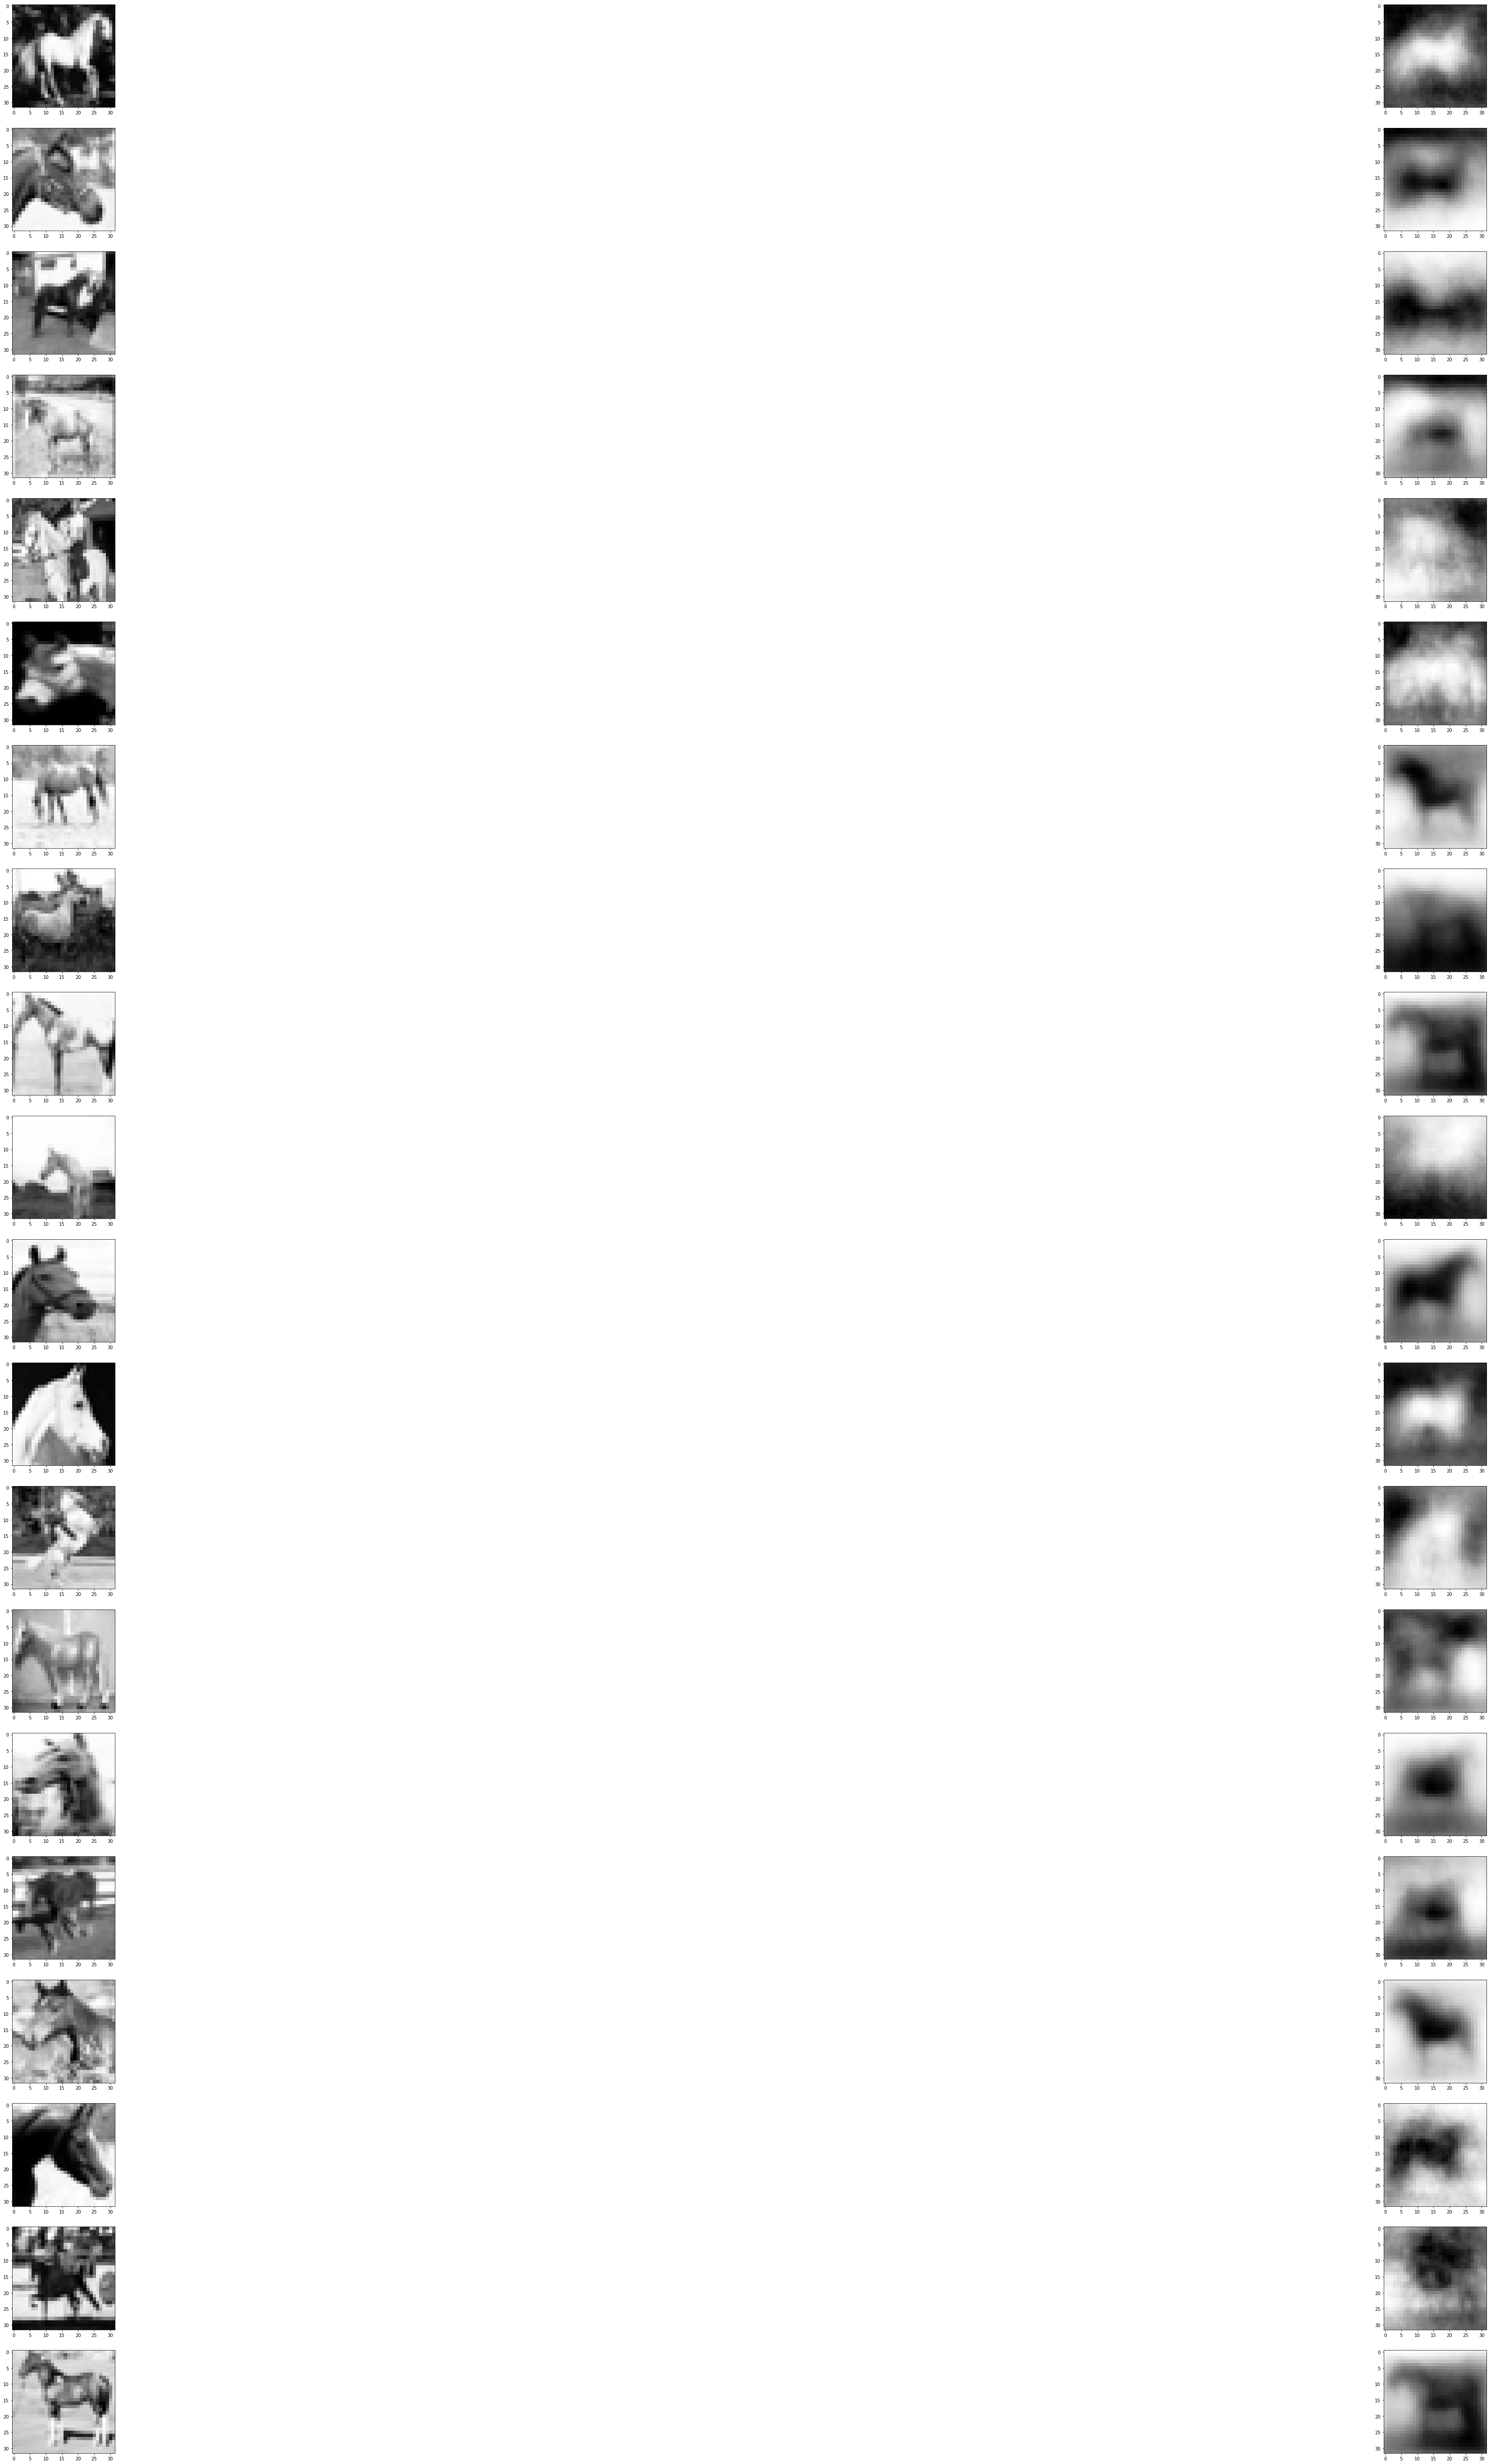

In [19]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_horse[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = ae_dn.decode([encodings_horse[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show()

In [25]:
input_dim = np.shape(horse_x)[1]
num_hidden_layers = 3
s_ae = StackedAutoencoder(input_dim, num_hidden_layers=num_hidden_layers)
s_ae.train(horse_x)

input to hidden layer 1, weights [1024, 512] biases 512
hidden layer 2, weights [512, 256] biases 256
hidden layer 3, weights [256, 512] biases 512
output layer, weights [512, 1024] biases 1024
epoch 0: loss = 5708.2119140625
epoch 1: loss = 3396.1689453125
epoch 2: loss = 3082.945556640625
epoch 3: loss = 2906.797119140625
epoch 4: loss = 2947.628173828125
epoch 5: loss = 2742.854248046875
epoch 6: loss = 2574.39404296875
epoch 7: loss = 2505.935302734375
epoch 8: loss = 2456.560791015625
epoch 9: loss = 2392.338134765625
epoch 10: loss = 2261.256591796875
epoch 11: loss = 2569.62646484375
epoch 12: loss = 2188.653076171875
epoch 13: loss = 2207.552001953125
epoch 14: loss = 2266.33056640625
epoch 15: loss = 2245.573486328125
epoch 16: loss = 2211.82080078125
epoch 17: loss = 2172.529052734375
epoch 18: loss = 2204.337646484375
epoch 19: loss = 2239.238037109375
epoch 20: loss = 2174.28662109375
epoch 21: loss = 2236.916259765625
epoch 22: loss = 2138.758056640625
epoch 23: loss = 219

In [26]:
s_ae.test(test_x)

INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[106.33333333 105.66666667 110.66666667 ...  75.          82.33333333
   66.        ]
 [235.         231.         232.         ... 176.33333333 188.66666667
  195.        ]
 [190.         187.66666667 166.33333333 ...   6.33333333   4.
    7.33333333]
 ...
 [ 15.66666667  14.66666667  13.33333333 ...  32.33333333  34.
   30.66666667]
 [ 25.66666667  18.          27.33333333 ...  99.          99.66666667
   97.33333333]
 [ 75.33333333 104.66666667 106.33333333 ... 108.33333333  63.66666667
   26.33333333]]
compressed [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
reconstructed [[111.93066   112.262405  113.22008   ...  83.891716   85.95943
   85.79143  ]
 [216.09158   221.30042   226.59193   ...  81.79205    83.837776
   83.61573  ]
 [235.71704   240.94913   245.95062   ...  42.53683    44.65908
   46.322422 ]
 ...
 [ 

array([[111.93066  , 112.262405 , 113.22008  , ...,  83.891716 ,
         85.95943  ,  85.79143  ],
       [216.09158  , 221.30042  , 226.59193  , ...,  81.79205  ,
         83.837776 ,  83.61573  ],
       [235.71704  , 240.94913  , 245.95062  , ...,  42.53683  ,
         44.65908  ,  46.322422 ],
       ...,
       [  3.270483 ,   1.0567667,   4.2971168, ..., 102.583885 ,
         99.18882  ,  99.671    ],
       [ 90.243904 ,  91.60423  ,  95.62648  , ..., 100.61708  ,
         98.93299  ,  99.46191  ],
       [148.90346  , 150.39445  , 152.11398  , ..., 101.880844 ,
        102.74512  , 103.36779  ]], dtype=float32)

In [27]:
test_data = unpickle('./cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])
test_horse_indices = np.where(test_labels==7)[0]
test_horse = test_x[test_horse_indices]
encodings = s_ae.classify(test_x, test_labels)
encodings_horse = encodings[test_horse_indices]

INFO:tensorflow:Restoring parameters from ./model.ckpt
data (10000, 1024)
reconstructed (1024,)
loss (10000,)
horse 65.17236194056699
not horse 64.06345316293603


INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

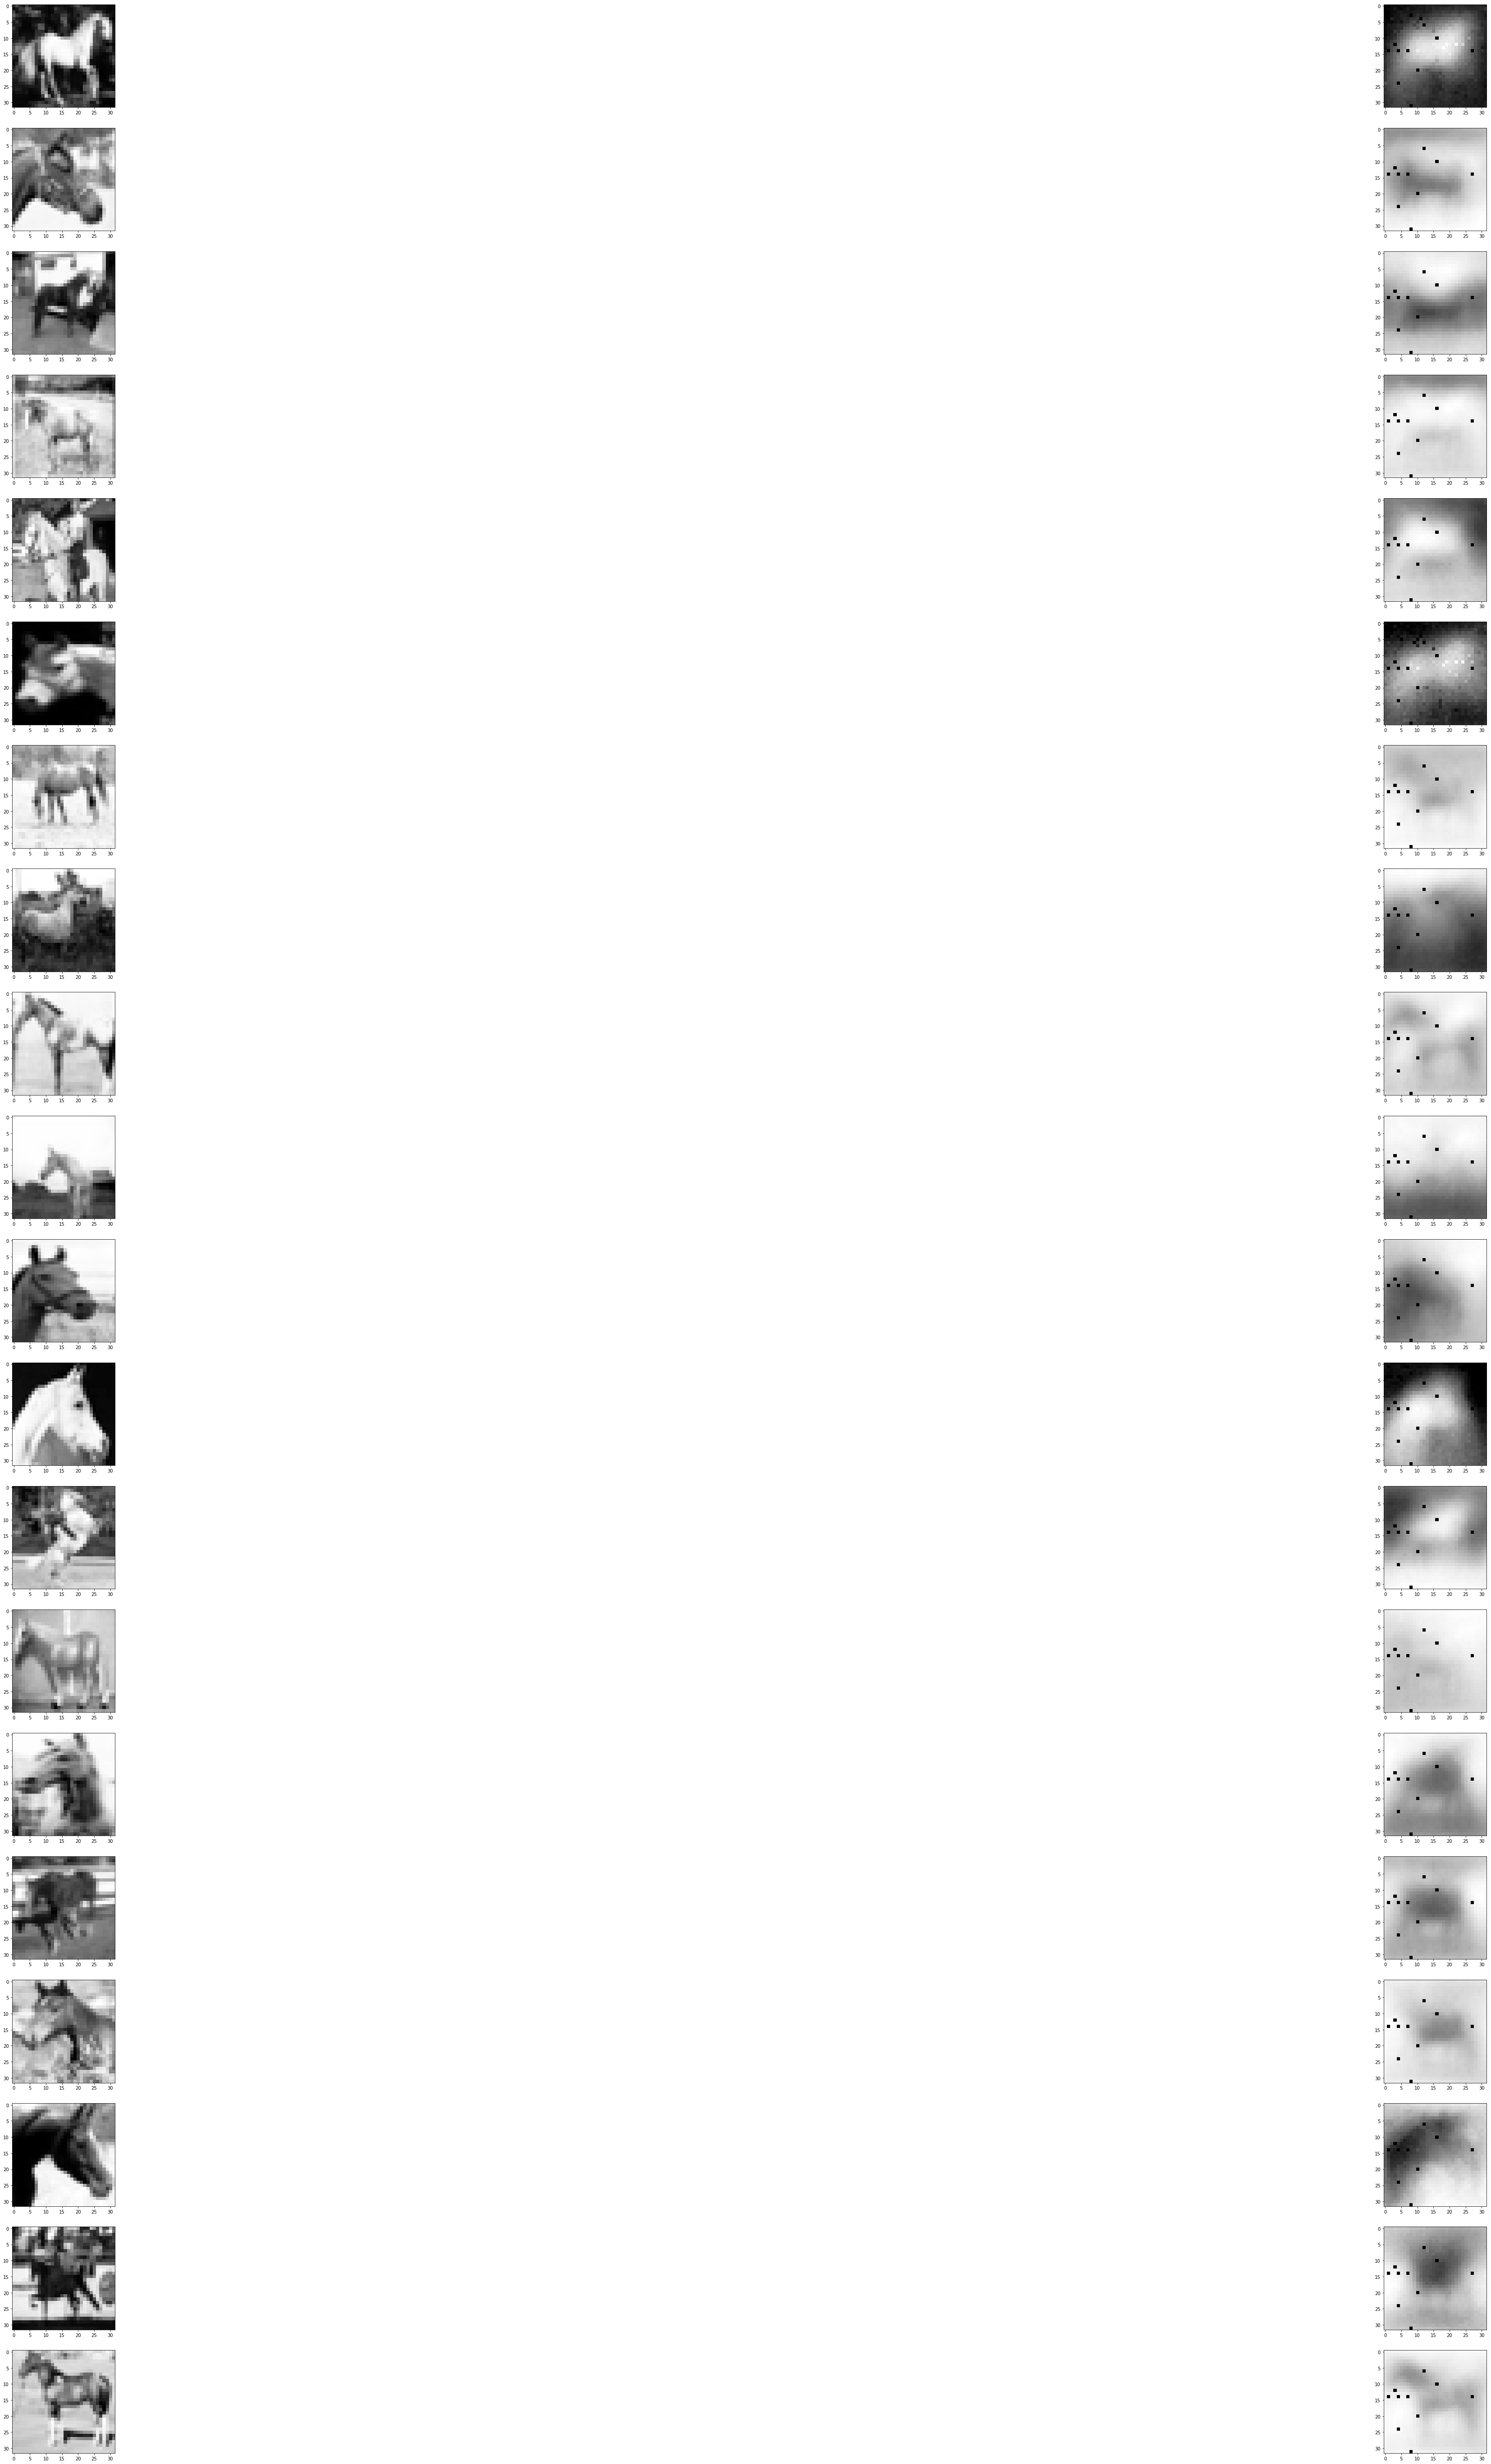

In [28]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_horse[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = s_ae.decode([encodings_horse[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show()

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

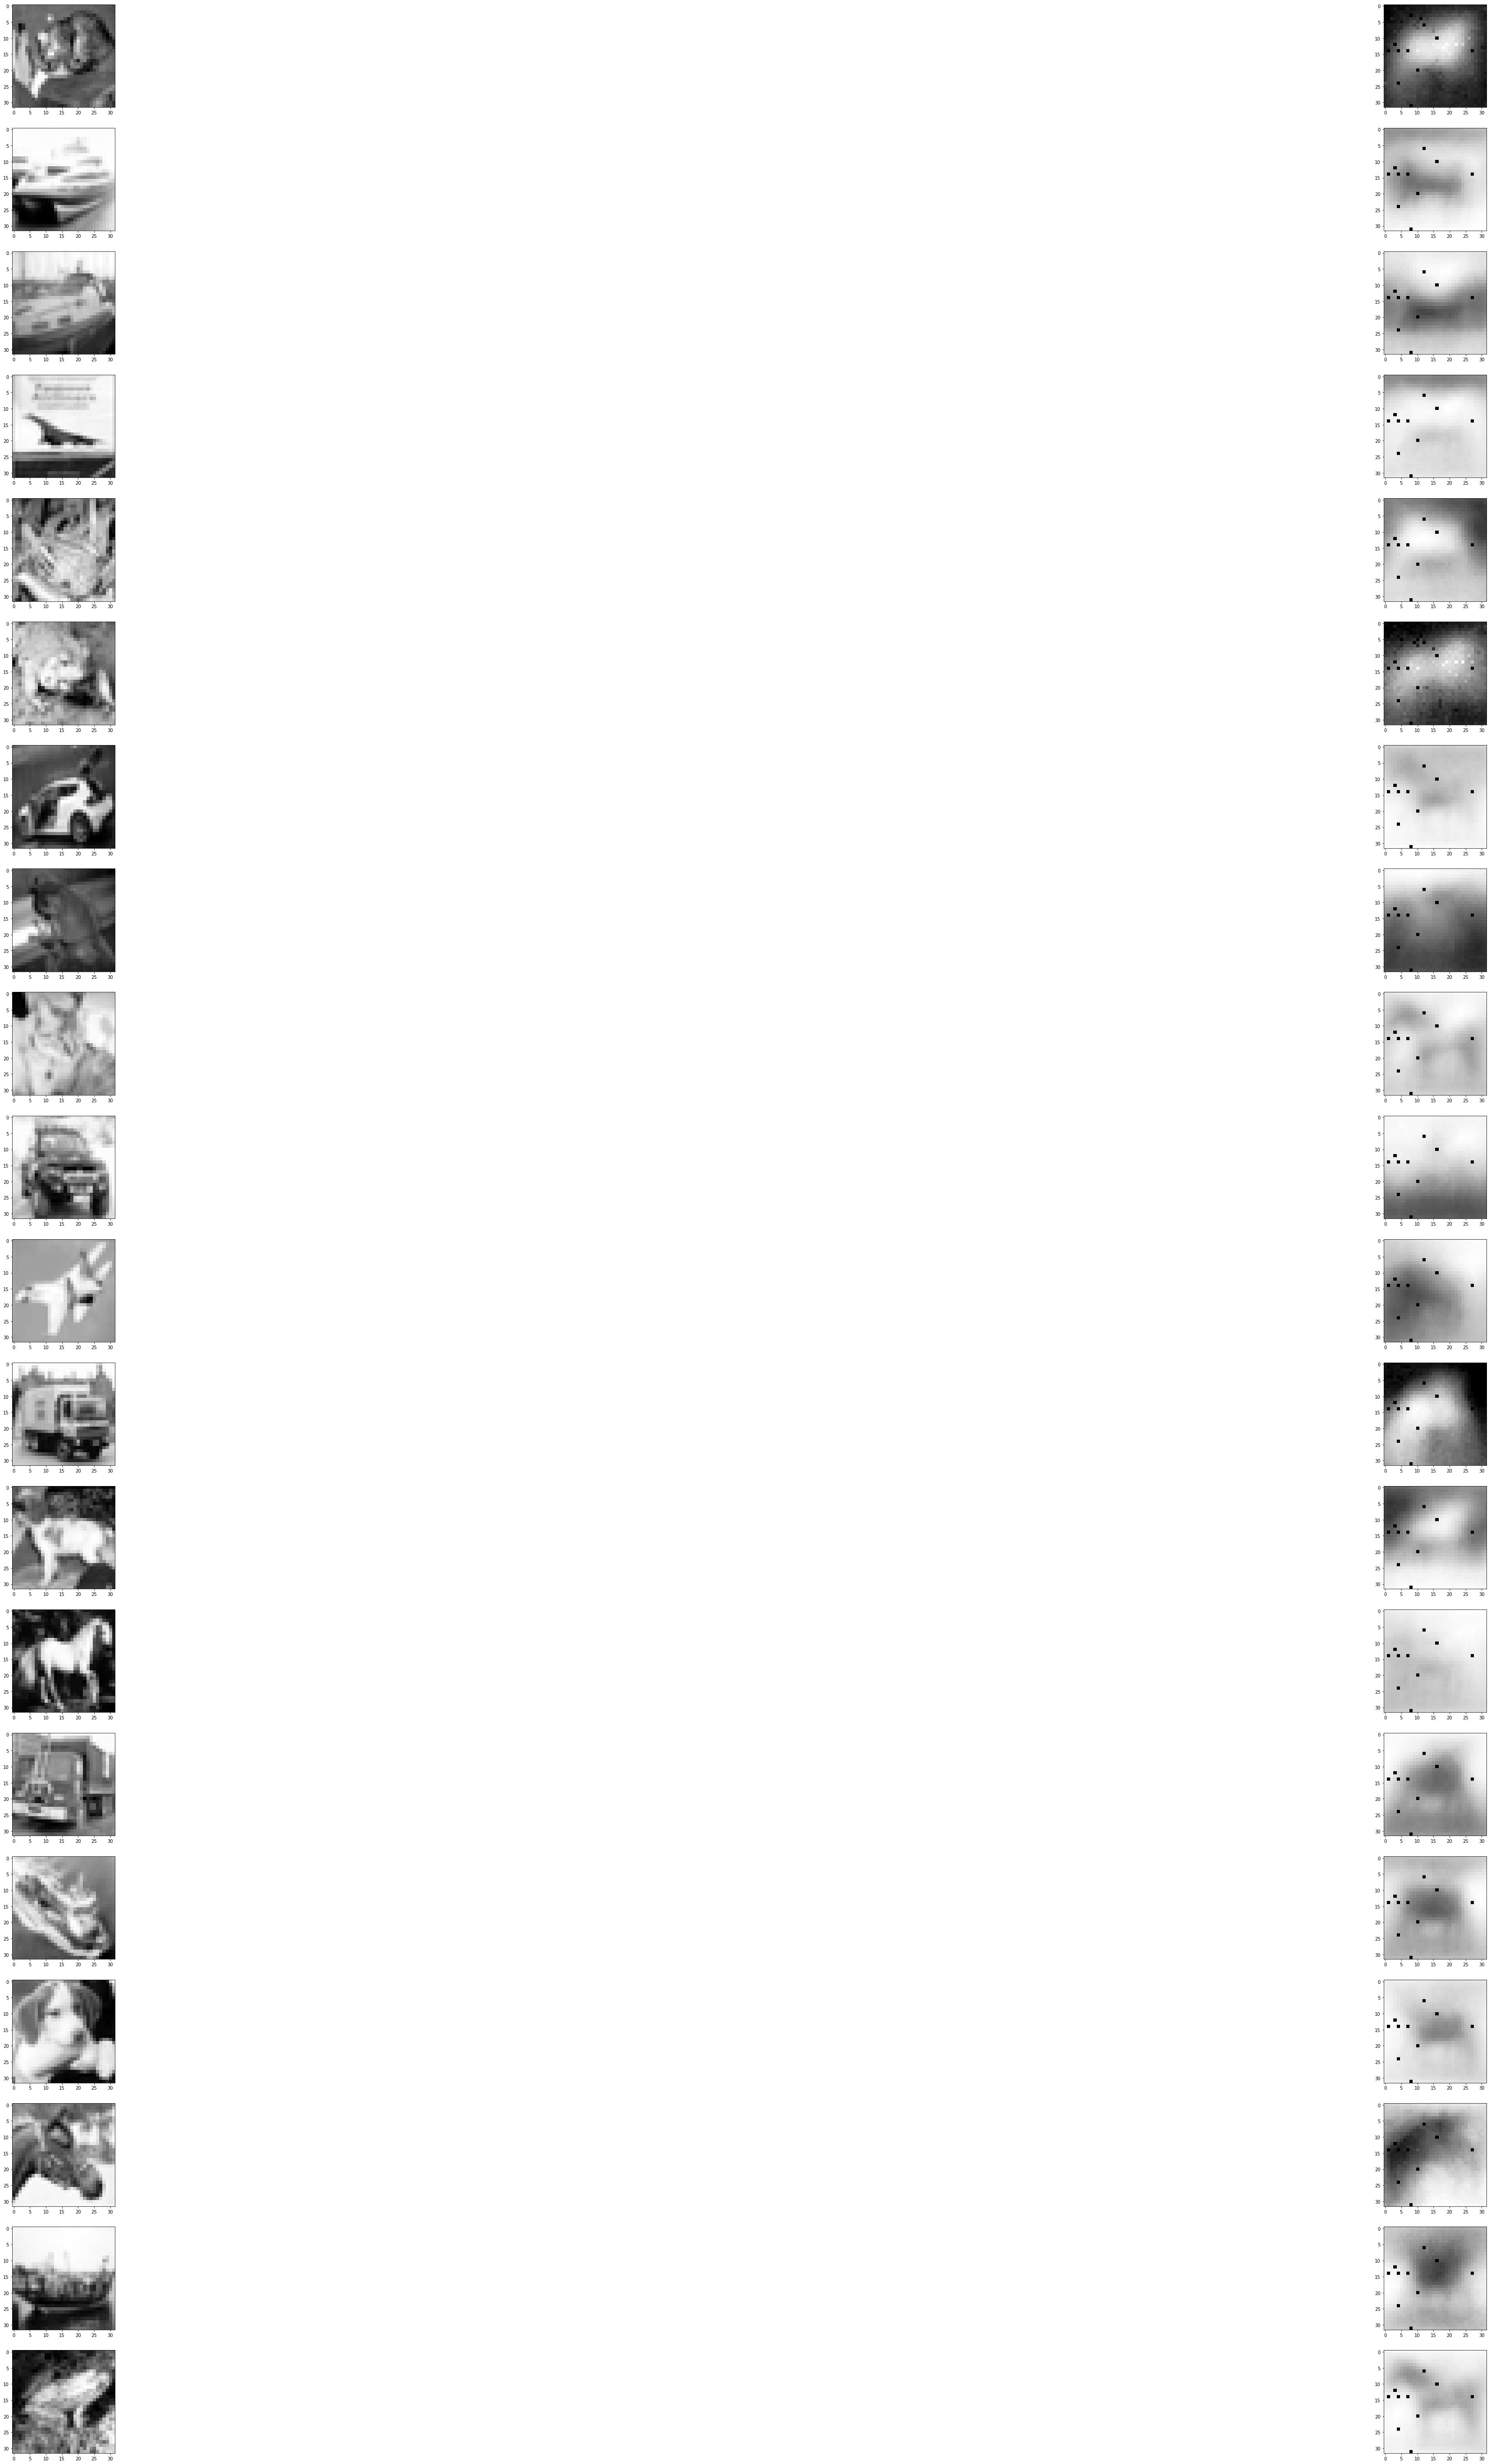

In [29]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_x[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = s_ae.results(test_horse[i, :].reshape(1,1024))
    plt.imshow(reconstructed_img.reshape(32,32), cmap='Greys_r')

plt.show()